In [2]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# Function

In [3]:
def boxplot_by_cluster(data, cluster_col='Cluster', figsize=(15, 10)):
  """
  Plots boxplots of numerical columns grouped by cluster.

  Parameters
  ----------
  data : pd.DataFrame
    DataFrame containing numerical features and cluster assignments.
  cluster_col : str, optional
    Name of the column representing cluster labels (default: 'Cluster').
  figsize : tuple, optional
    Figure size for the plot (default: (15, 10)).
  """
  plt.figure(figsize=figsize, constrained_layout=True)
  numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
  numerical_cols = [col for col in numerical_cols if not col.startswith(cluster_col)]

  for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=data, x=cluster_col, y=col, hue=cluster_col, palette='cividis') # viridis
    plt.title(f'Boxplot of {col}', fontsize=8)
    plt.xlabel(cluster_col, fontsize=8)
    plt.ylabel(col)
    plt.legend([], [], frameon=False)
  plt.show()

In [4]:
customer = pd.read_csv('Part A/customer_data.csv')

display(customer.head())
customer = customer.drop(columns=['CustomerID'])
print(customer.describe())
print("Number of null values in each column:")
print(customer.isna().sum())

,CustomerID,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
0,1,Male,19,15,39,1.054960,0.036968,1
1,2,Male,21,15,81,0.676210,0.119785,1
2,3,Female,20,16,6,0.562232,0.010672,1
3,4,Female,23,16,77,1.284359,0.059952,1
4,5,Female,31,17,40,0.806683,0.049586,1


              Age  Income (k$)  How Much They Spend ($)  Salary (k$)  \
count  200.000000   200.000000               200.000000   200.000000   
mean    38.850000    60.560000                50.200000     4.538022   
std     13.969007    26.264721                25.823522     2.214437   
min     18.000000    15.000000                 1.000000     0.562232   
25%     28.750000    41.500000                34.750000     2.963534   
50%     36.000000    61.500000                50.000000     4.577495   
75%     49.000000    78.000000                73.000000     5.905840   
max     70.000000   137.000000                99.000000    11.133367   

       Spend to income ratio      Alpha  
count             200.000000  200.00000  
mean                0.015816    2.50000  
std                 0.017091    1.12084  
min                 0.000157    1.00000  
25%                 0.008362    1.75000  
50%                 0.012212    2.50000  
75%                 0.015903    3.25000  
max            

# EDA

In [5]:
customer.columns.tolist()

['Gender',
 'Age',
 'Income (k$)',
 'How Much They Spend ($)',
 'Salary (k$)',
 'Spend to income ratio',
 'Alpha']

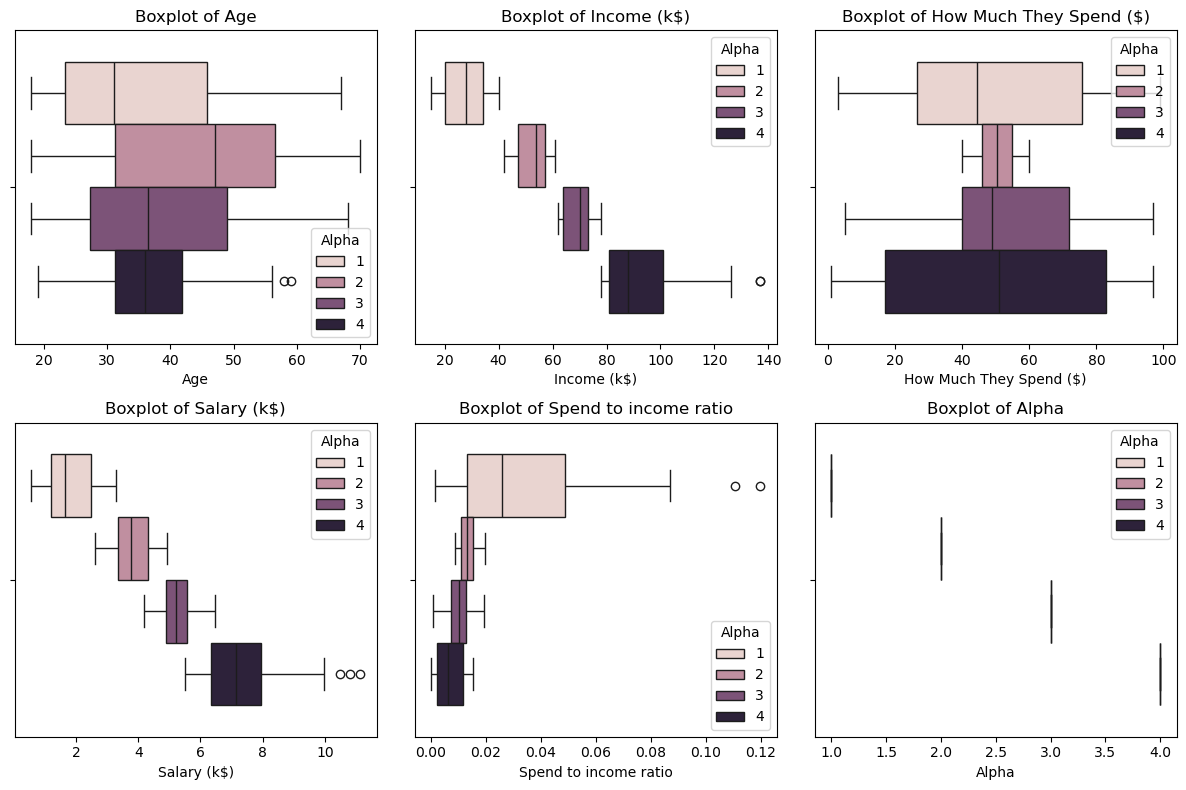

In [6]:
# Plotting the numerical features to visualize outliers
numerical_cols = customer.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
  plt.subplot(2, 3, i + 1)
  sns.boxplot(data=customer, x=col, hue="Alpha")
  plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

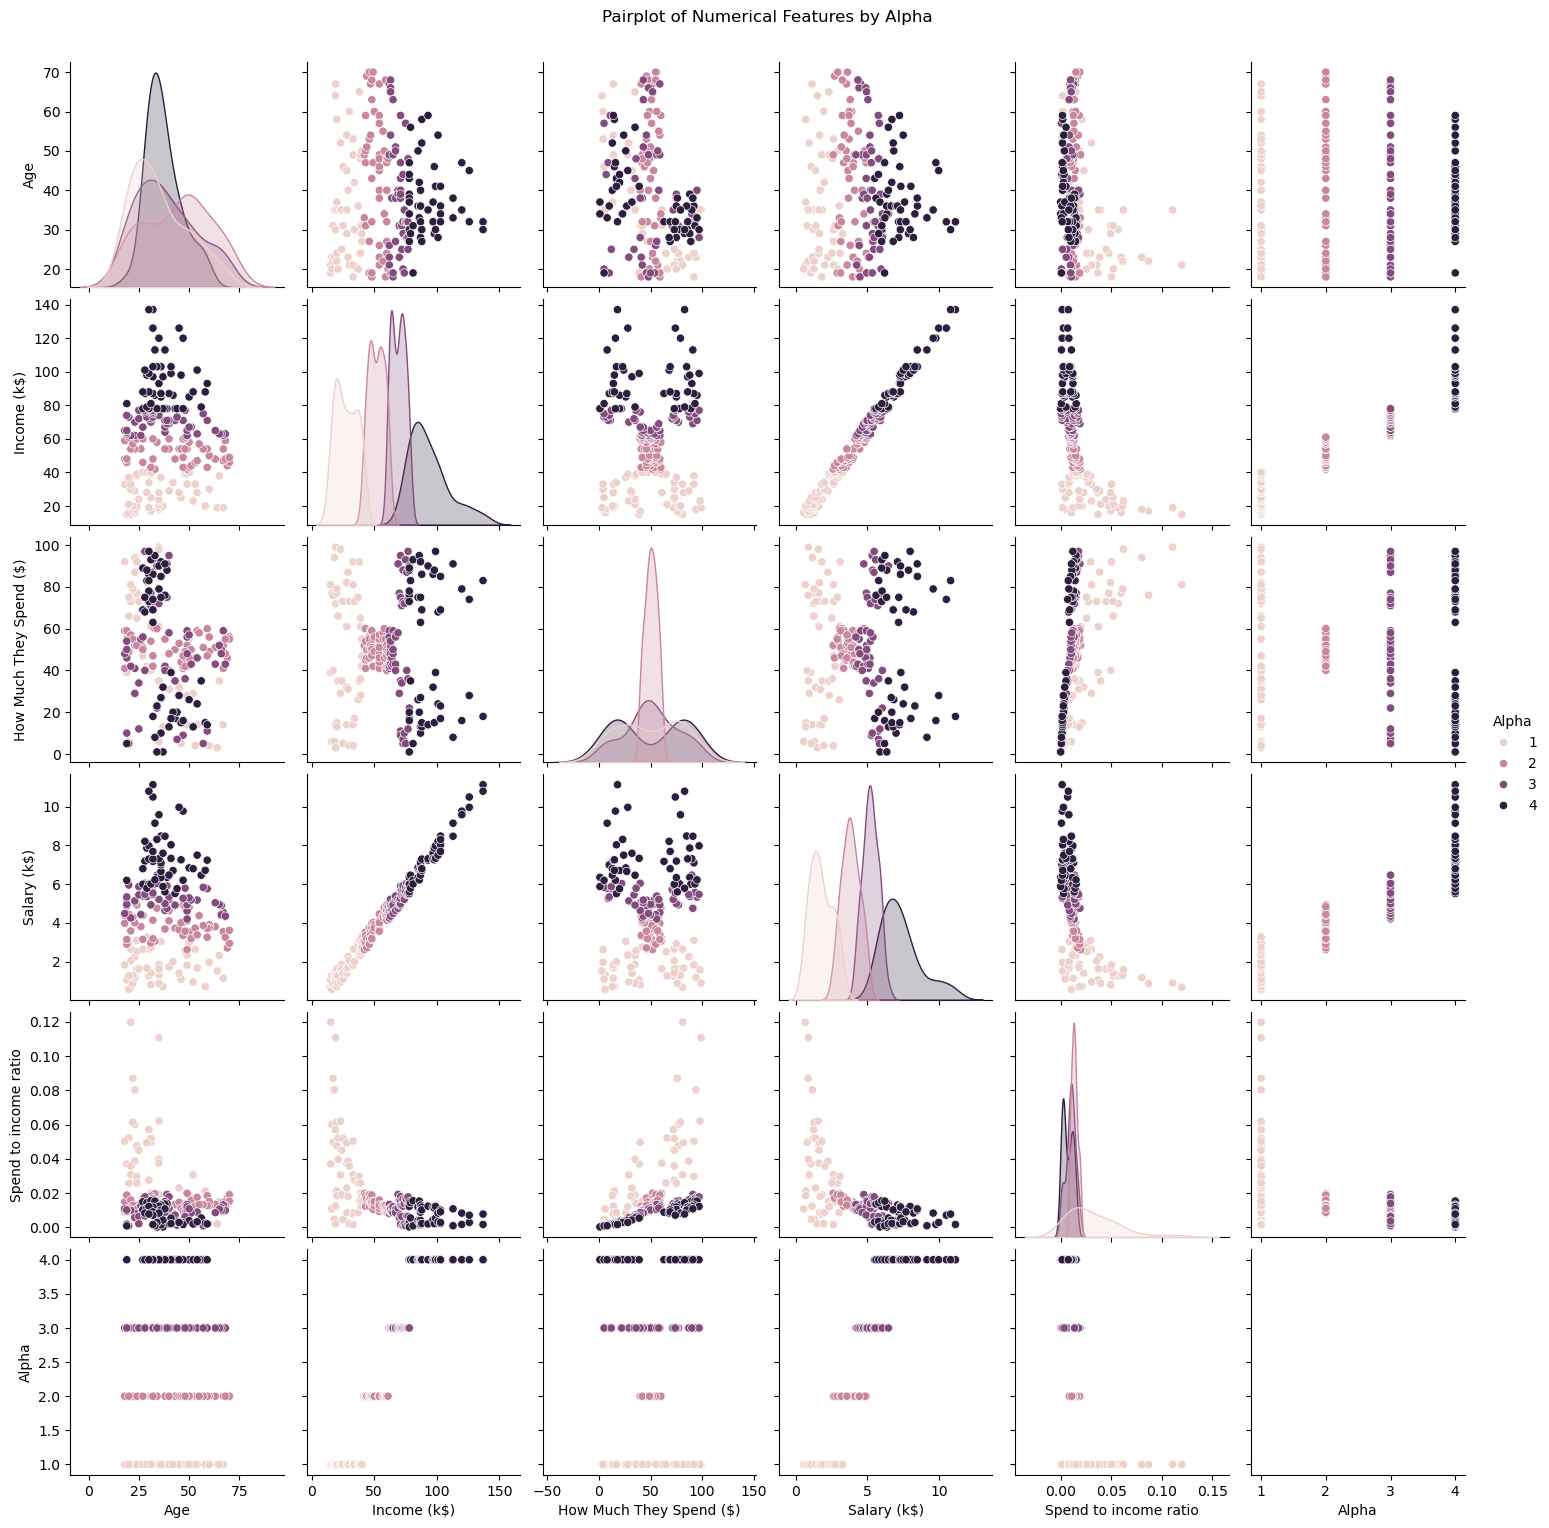

In [7]:
# pair plot to visualize relationships between numerical features
g = sns.pairplot(customer, hue='Alpha', vars=numerical_cols)
g.figure.suptitle('Pairplot of Numerical Features by Alpha', y=1.02)
plt.show()

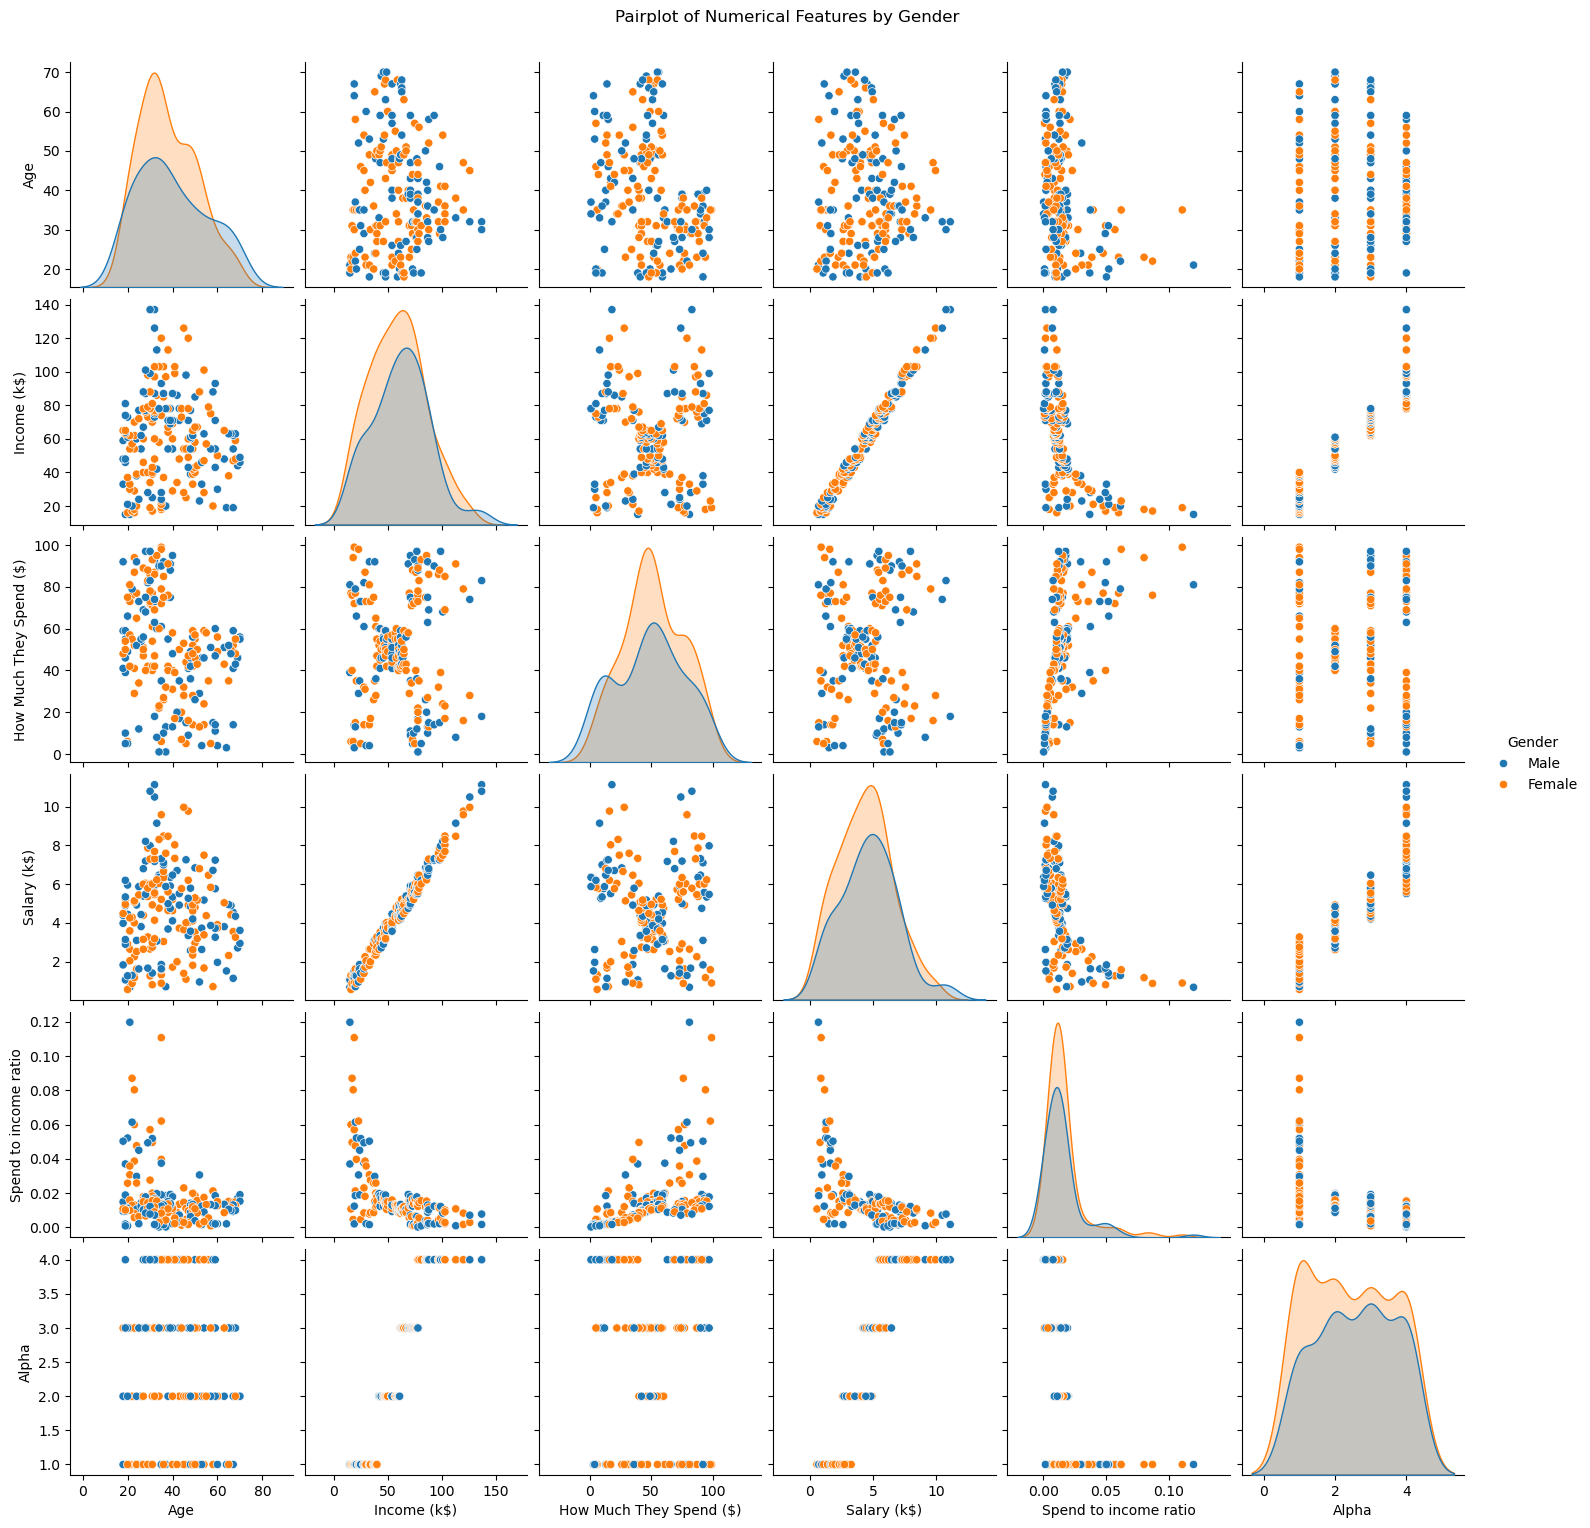

In [8]:
# pair plot to visualize relationships between numerical features
g = sns.pairplot(customer, hue='Gender', vars=numerical_cols)
g.figure.suptitle('Pairplot of Numerical Features by Gender', y=1.02)
plt.show()

# Data transformation

Transform the numerical features using StandardScaler to have 0 means and 1 variance

In [9]:
numerical_cols = customer.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = ["Gender"]

# preprocessing steps
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

pipeline_transform = Pipeline([
    ('preprocessor', preprocessor)
])


In [10]:
customer_transform = pipeline_transform.fit_transform(customer)

categorical_feature_names = pipeline_transform.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['Gender'])
numerical_feature_names = numerical_cols.tolist()
feature_names = np.concatenate([numerical_feature_names, categorical_feature_names]) 

customer_transform_df = pd.DataFrame(customer_transform, columns=feature_names)
display(customer_transform_df.head())
print("Descriptive statistics of transformed data:")
print(customer_transform_df.describe())

,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha,Gender_Male
0,-1.424569,-1.738999,-0.434801,-1.576835,1.240737,-1.341641,1.0
1,-1.281035,-1.738999,1.195704,-1.748301,6.098642,-1.341641,1.0
2,-1.352802,-1.700830,-1.715913,-1.799901,-0.301771,-1.341641,0.0
3,-1.137502,-1.700830,1.040418,-1.472983,2.588929,-1.341641,0.0
4,-0.563369,-1.662660,-0.395980,-1.689234,1.980859,-1.341641,0.0


Descriptive statistics of transformed data:
                Age   Income (k$)  How Much They Spend ($)   Salary (k$)  \
count  2.000000e+02  2.000000e+02             2.000000e+02  2.000000e+02   
mean  -1.021405e-16 -2.131628e-16            -1.465494e-16 -7.105427e-17   
std    1.002509e+00  1.002509e+00             1.002509e+00  1.002509e+00   
min   -1.496335e+00 -1.738999e+00            -1.910021e+00 -1.799901e+00   
25%   -7.248436e-01 -7.275093e-01            -5.997931e-01 -7.127949e-01   
50%   -2.045351e-01  3.587926e-02            -7.764312e-03  1.786994e-02   
75%    7.284319e-01  6.656748e-01             8.851316e-01  6.192318e-01   
max    2.235532e+00  2.917671e+00             1.894492e+00  2.985813e+00   

       Spend to income ratio         Alpha  Gender_Male  
count             200.000000  2.000000e+02   200.000000  
mean                0.000000 -7.105427e-17     0.440000  
std                 1.002509  1.002509e+00     0.497633  
min                -0.918524 -1.341641e

# KMeans

## choosing n_clusters using the elbow method

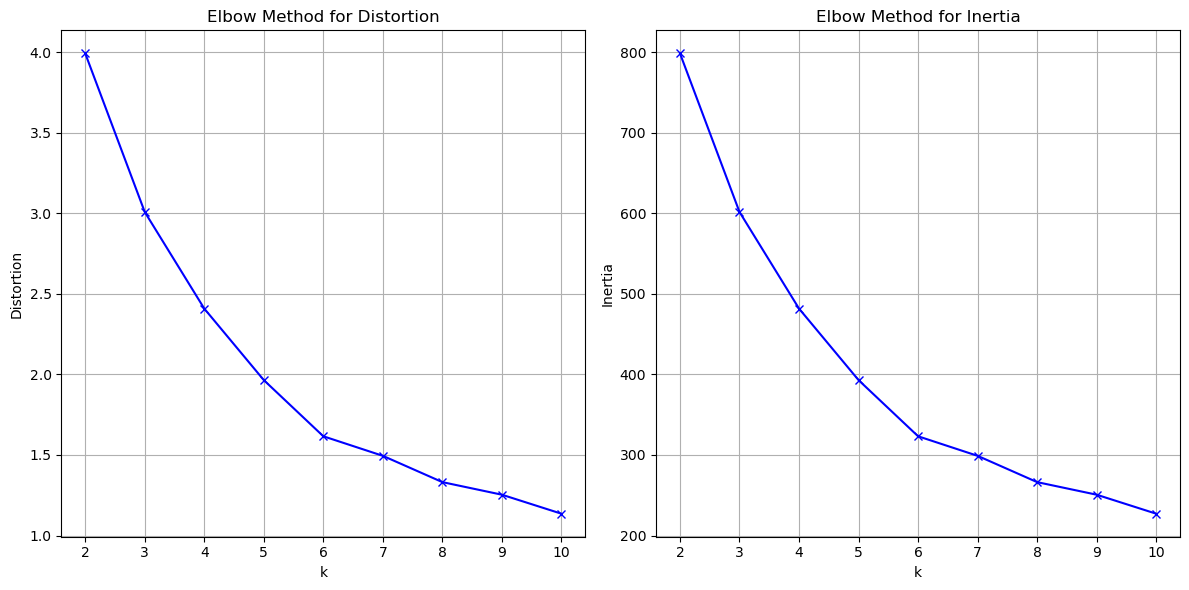

Distortion values:
2 : 3.993974002250099
3 : 3.0090533557254746
4 : 2.409006059069258
5 : 1.9649443127869315
6 : 1.6161449638524197
7 : 1.49473200100746
8 : 1.3314350833592774
9 : 1.253302051426047
10 : 1.1353551859504842

Inertia values:
2 : 798.7948004500197
3 : 601.810671145095
4 : 481.80121181385147
5 : 392.98886255738626
6 : 323.2289927704836
7 : 298.9464002014919
8 : 266.28701667185555
9 : 250.6604102852094
10 : 227.07103719009683


In [11]:
# Using Elbow method to choose n_cluster

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 11)

for k in K:
  kmeanModel = KMeans(n_clusters=k, random_state=42).fit(customer_transform)
  distortions.append(
    sum(np.min(cdist(customer_transform, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / customer_transform.shape[0]
  )
  inertias.append(kmeanModel.inertia_)
  mapping1[k] = distortions[-1]
  mapping2[k] = inertias[-1]

# Plotting the elbow curve for distortions and inertias
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for Distortion')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Inertia')
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

print("Distortion values:")
for key, val in mapping1.items():
  print(f'{key} : {val}')

print()
print("Inertia values:")
for key, val in mapping2.items():
  print(f'{key} : {val}')

## choosing n_clusters using silhouette scores

Silhouette Score Analysis:
----------------------------------------
k= 2: Silhouette Score = 0.3088
k= 3: Silhouette Score = 0.3089
k= 4: Silhouette Score = 0.3335
k= 5: Silhouette Score = 0.3274
k= 6: Silhouette Score = 0.3505
k= 7: Silhouette Score = 0.3274
k= 8: Silhouette Score = 0.3221
k= 9: Silhouette Score = 0.2974
k=10: Silhouette Score = 0.2820

Optimal k based on Silhouette Score: 6 (Score: 0.3505)


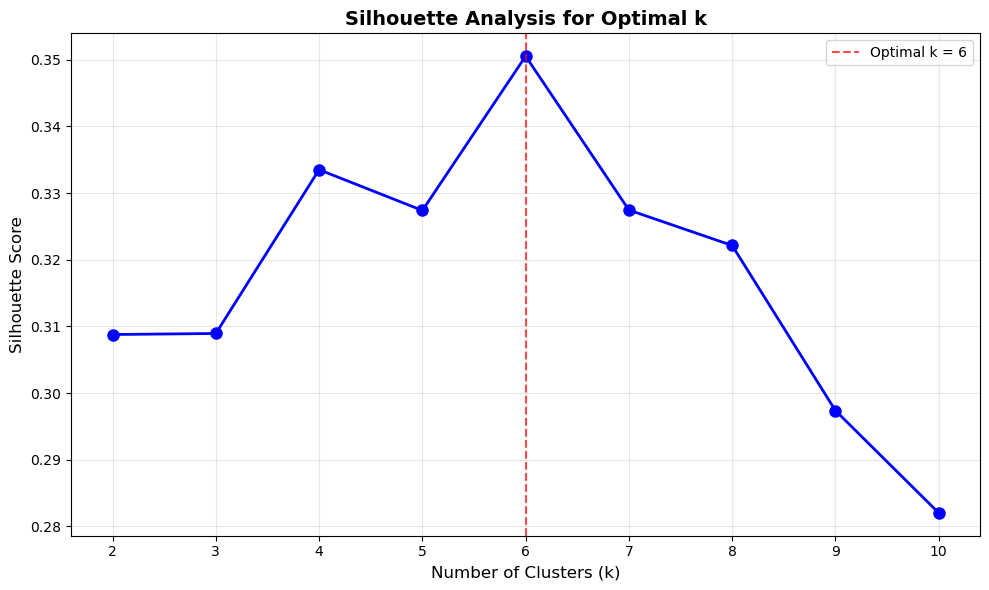

In [12]:
# Calculate silhouette scores for different k values
silhouette_scores = []
k_silhouette_mapping = {}

print("Silhouette Score Analysis:")
print("-" * 40)

for k in K:
  kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
  cluster_labels = kmeans.fit_predict(customer_transform)
  silhouette_avg = silhouette_score(customer_transform, cluster_labels, metric="euclidean")
  silhouette_scores.append(silhouette_avg)
  k_silhouette_mapping[k] = silhouette_avg
  print(f"k={k:2d}: Silhouette Score = {silhouette_avg:.4f}")

# Find optimal k based on silhouette score
if k_silhouette_mapping:  # Check if dictionary is not empty
  optimal_k = max(k_silhouette_mapping, key=k_silhouette_mapping.get)
  print(f"\nOptimal k based on Silhouette Score: {optimal_k} (Score: {k_silhouette_mapping[optimal_k]:.4f})")
else:
  print("No clusters evaluated!")
  optimal_k = 2

# Plotting silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.title('Silhouette Analysis for Optimal k', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 11))

# Highlight optimal k
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal k = {optimal_k}')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

## Anomaly

In [13]:
def detect_anomalies(features: np.ndarray, kmeans: KMeans, n_anomalies: int = 5) -> tuple:
  """
  Detect anomalies based on distance to the closest centroid.
  
  Parameters
  ----------
  features : np.ndarray
    Feature matrix of shape (n_samples, n_features)
  kmeans : KMeans
    Fitted K-means model
  n_anomalies : int, optional
    Number of anomalies to detect, by default 5
  
  Returns
  -------
  tuple
    - anomaly_indices: Indices of detected anomalies
    - features_without_anomalies: Data with anomalies removed
    - anomaly_data: Data points identified as anomalies
    - distances: Distances from each point to nearest centroid

  Raises
  ------
  ValueError
    If n_anomalies is greater than the number of samples
  """
  # Validate input parameters
  if n_anomalies > features.shape[0]:
    raise ValueError(
      f"n_anomalies ({n_anomalies}) cannot be greater than "
      f"number of samples ({features.shape[0]})"
    )

  # Calculate distances to closest centroid for each point
  distances = kmeans.transform(features).min(axis=1)

  # Identify points with largest distances (potential anomalies)
  anomaly_indices = np.argsort(distances)[::-1][:n_anomalies]

  # Display detection statistics
  print("Anomaly Detection Statistics:")
  print("-" * 30)
  print(f"Total samples: {features.shape[0]}")
  print(f"Number of Anomalies set: {n_anomalies}")
  print(f"Mean distance to centroid: {distances.mean():.3f}")
  print(f"Std distance to centroid: {distances.std():.3f}")
  print(f"Max anomaly distance: {distances[anomaly_indices[0]]:.3f}")
  print(f"Min anomaly distance: {distances[anomaly_indices[-1]]:.3f}")
  
  return anomaly_indices, distances

# Detect anomalies


KMeans(n_clusters=6)
Anomaly Detection Statistics:
------------------------------
Total samples: 200
Number of Anomalies set: 5
Mean distance to centroid: 1.177
Std distance to centroid: 0.477
Max anomaly distance: 3.945
Min anomaly distance: 2.420


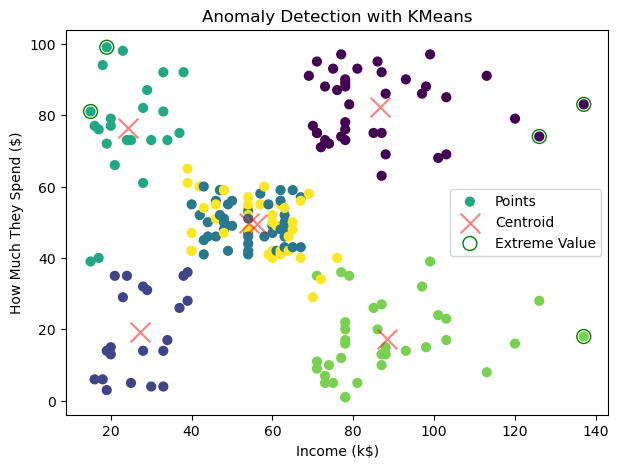

Anomalies from the original data:
     Gender  Age  Income (k$)  How Much They Spend ($)  Salary (k$)  \
1      Male   21           15                       81     0.676210   
11   Female   35           19                       99     0.893771   
198    Male   32          137                       18    11.133367   
199    Male   30          137                       83    10.796760   
197    Male   32          126                       74    10.497569   

     Spend to income ratio  Alpha  
1                 0.119785      1  
11                0.110767      1  
198               0.001617      4  
199               0.007687      4  
197               0.007049      4  


In [14]:
cluster = 6

kmeans = KMeans(n_clusters=cluster)
kmeans.fit(customer_transform)
print(kmeans)
y_kmeans = kmeans.predict(customer_transform)
centers = kmeans.cluster_centers_
# Use the fitted scaler from the pipeline
fitted_scaler = pipeline_transform.named_steps['preprocessor'].named_transformers_['num']
centers_inv = fitted_scaler.inverse_transform(centers[:, :-1])
sorted_idx, distances = detect_anomalies(customer_transform_df.values, kmeans, n_anomalies= 5)

# Visualize the results
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Anomaly Detection with KMeans")
ax.scatter(customer["Income (k$)"], customer["How Much They Spend ($)"], c=y_kmeans, s=40, cmap='viridis',label='Points')
ax.scatter(centers_inv[:, 1], centers_inv[:, 2], label='Centroid', color='r',  marker='x',s=200, alpha=0.5)
ax.scatter(customer.iloc[sorted_idx]['Income (k$)'], 
           customer.iloc[sorted_idx]["How Much They Spend ($)"], 
           label='Extreme Value', edgecolors='g', facecolors='none', s=100)
ax.legend(loc='best')
plt.xlabel("Income (k$)")
plt.ylabel("How Much They Spend ($)")
plt.show()
# It's easy to remove these points if we like:
# new_Customer = np.delete(customer_transform, sorted_idx, axis=0)
new_Customer_transformed = customer_transform_df.drop(customer_transform_df.index[sorted_idx])
new_Customer = customer.drop(customer.index[sorted_idx])
# Or to extract the anomalies
anomaly = customer.iloc[sorted_idx]
anomaly_transformed = customer_transform_df.iloc[sorted_idx]
print("Anomalies from the original data:")
print(anomaly)

## PCA Dimension reduction

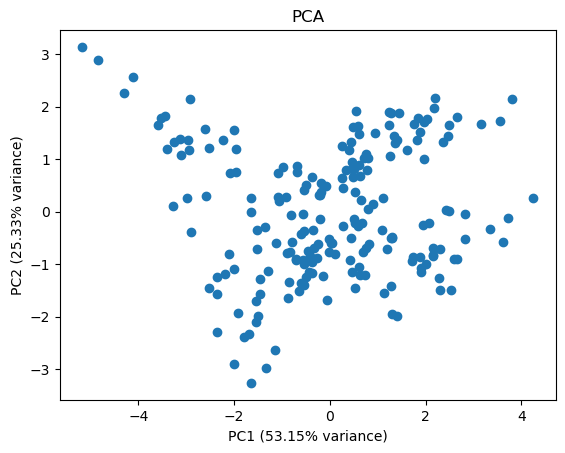

In [15]:
# Apply PCA with two components (for 2D visualization)
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(customer_transform)
# Plot the results
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1])
plt.title('PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()

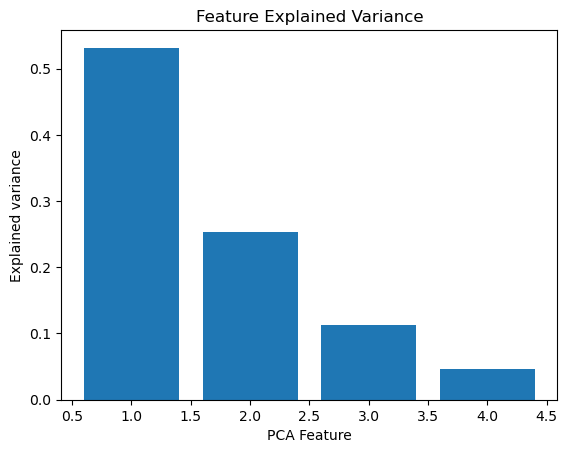

In [16]:
# Analyzing explained variance for customer dataset features
pca = PCA(n_components=4)
# Fit and transform data
pca_features = pca.fit_transform(customer_transform)
# Bar plot of explained_variance_ratio_
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),
pca.explained_variance_ratio_)
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

## KMeans with PCA

In [17]:
from sklearn.model_selection import ParameterGrid

param_grid = {"pca__n_components": [2, 3, 4],
              "kmeans__n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid = ParameterGrid(param_grid)
results = {}
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(random_state=42)),
    ('kmeans', KMeans(random_state=42))
])
for params in grid:
    # Set parameters for PCA and KMeans
    pipeline.set_params(**params)
    # Fit the pipeline and predict clusters
    cluster_labels = pipeline.fit_predict(customer)
    
    # Calculate silhouette score
    score = silhouette_score(pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(customer)), cluster_labels)
    explained_variance = pipeline.named_steps['pca'].explained_variance_ratio_.sum()
    print(f"Evaluating: {params}")
    print(f"PCA={params['pca__n_components']}, Clusters={params['kmeans__n_clusters']}: "
      f"Silhouette={silhouette_avg:.4f}, "
      f"Variance={explained_variance:.3f}")
    key = f"PCA_{params['pca__n_components']}_KMeans_{params['kmeans__n_clusters']}"
    results[key] = {
      'pca_components': params['pca__n_components'],
      'n_clusters': params['kmeans__n_clusters'],
      'silhouette_score': score,
      'explained_variance': explained_variance,
      # params key, value pair
      'params': params
      }





Evaluating: {'kmeans__n_clusters': 2, 'pca__n_components': 2}
PCA=2, Clusters=2: Silhouette=0.2820, Variance=0.785
Evaluating: {'kmeans__n_clusters': 2, 'pca__n_components': 3}
PCA=3, Clusters=2: Silhouette=0.2820, Variance=0.898
Evaluating: {'kmeans__n_clusters': 2, 'pca__n_components': 4}
PCA=4, Clusters=2: Silhouette=0.2820, Variance=0.945
Evaluating: {'kmeans__n_clusters': 3, 'pca__n_components': 2}
PCA=2, Clusters=3: Silhouette=0.2820, Variance=0.785
Evaluating: {'kmeans__n_clusters': 3, 'pca__n_components': 3}
PCA=3, Clusters=3: Silhouette=0.2820, Variance=0.898
Evaluating: {'kmeans__n_clusters': 3, 'pca__n_components': 4}
PCA=4, Clusters=3: Silhouette=0.2820, Variance=0.945
Evaluating: {'kmeans__n_clusters': 4, 'pca__n_components': 2}
PCA=2, Clusters=4: Silhouette=0.2820, Variance=0.785
Evaluating: {'kmeans__n_clusters': 4, 'pca__n_components': 3}
PCA=3, Clusters=4: Silhouette=0.2820, Variance=0.898
Evaluating: {'kmeans__n_clusters': 4, 'pca__n_components': 4}
PCA=4, Clusters=4:

In [18]:
# Find best combinations
best_silhouette = max(results.items(), key=lambda x: x[1]['silhouette_score'])
best_variance = max(results.items(), key=lambda x: x[1]['explained_variance'])

print("ANALYSIS SUMMARY")
print(f"\nBest Silhouette Score:")
print(f"  Configuration: {best_silhouette[0]}")
print(f"  Score: {best_silhouette[1]['silhouette_score']:.4f}")
print(f"  PCA Components: {best_silhouette[1]['pca_components']}")
print(f"  Clusters: {best_silhouette[1]['n_clusters']}")
print(f"  Explained Variance: {best_silhouette[1]['explained_variance']:.3f}")

print(f"\nHighest Explained Variance:")
print(f"  Configuration: {best_variance[0]}")
print(f"  Variance: {best_variance[1]['explained_variance']:.3f}")
print(f"  PCA Components: {best_variance[1]['pca_components']}")
print(f"  Clusters: {best_variance[1]['n_clusters']}")
print(f"  Silhouette Score: {best_variance[1]['silhouette_score']:.4f}")

best_silhouette_params = best_silhouette[1]['params']

ANALYSIS SUMMARY

Best Silhouette Score:
  Configuration: PCA_2_KMeans_4
  Score: 0.4310
  PCA Components: 2
  Clusters: 4
  Explained Variance: 0.785

Highest Explained Variance:
  Configuration: PCA_4_KMeans_2
  Variance: 0.945
  PCA Components: 4
  Clusters: 2
  Silhouette Score: 0.3280


## Cluster label

KMeans with 4 cluster and PCA 2 components

In [19]:
pipeline.set_params(**best_silhouette_params)

cluster_labels = pipeline.fit_predict(customer)
customer_predicted = customer.copy()

customer_predicted['Cluster'] = cluster_labels
print("\nPredicted Clusters:")
print(customer_predicted)

distances = pipeline.transform(customer).min(axis=1)
n_anomalies = 3

# Identify points with largest distances (potential anomalies)
anomaly_indices = np.argsort(distances)[::-1][:n_anomalies]

# Display anomaly statistics
print("\nAnomaly Detection Statistics:")
print("-" * 30)
print(f"Total samples: {customer.shape[0]}")
print(f"Number of Anomalies set: {n_anomalies}")
print(f"Mean distance to centroid: {distances.mean():.3f}")
print(f"Std distance to centroid: {distances.std():.3f}")
print(f"Max anomaly distance: {distances[anomaly_indices[0]]:.3f}")
print(f"Min anomaly distance: {distances[anomaly_indices[-1]]:.3f}")  

print("Anomaly Records")
anomaly_df = customer_predicted.iloc[anomaly_indices, :]
display(anomaly_df)


Predicted Clusters:
     Gender  Age  Income (k$)  How Much They Spend ($)  Salary (k$)  \
0      Male   19           15                       39     1.054960   
1      Male   21           15                       81     0.676210   
2    Female   20           16                        6     0.562232   
3    Female   23           16                       77     1.284359   
4    Female   31           17                       40     0.806683   
..      ...  ...          ...                      ...          ...   
195  Female   35          120                       79     9.581893   
196  Female   45          126                       28     9.966931   
197    Male   32          126                       74    10.497569   
198    Male   32          137                       18    11.133367   
199    Male   30          137                       83    10.796760   

     Spend to income ratio  Alpha  Cluster  
0                 0.036968      1        2  
1                 0.119785      1   

,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha,Cluster
198,Male,32,137,18,11.133367,0.001617,4,3
1,Male,21,15,81,0.676210,0.119785,1,2
199,Male,30,137,83,10.796760,0.007687,4,1


In [20]:
feature_names = [p.split('__')[1] for p in pipeline.named_steps["preprocessor"].get_feature_names_out()]
pca_components = pipeline.named_steps["pca"].components_
pd.DataFrame(pca_components, columns=feature_names, index=[f'PC{i+1}' for i in range(pca_components.shape[0])])

,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha,Gender_Male
PC1,0.056365,0.530884,-0.086824,0.528402,-0.405556,0.513170,0.020472
PC2,-0.574183,0.157936,0.664878,0.162320,0.390621,0.154605,-0.021740


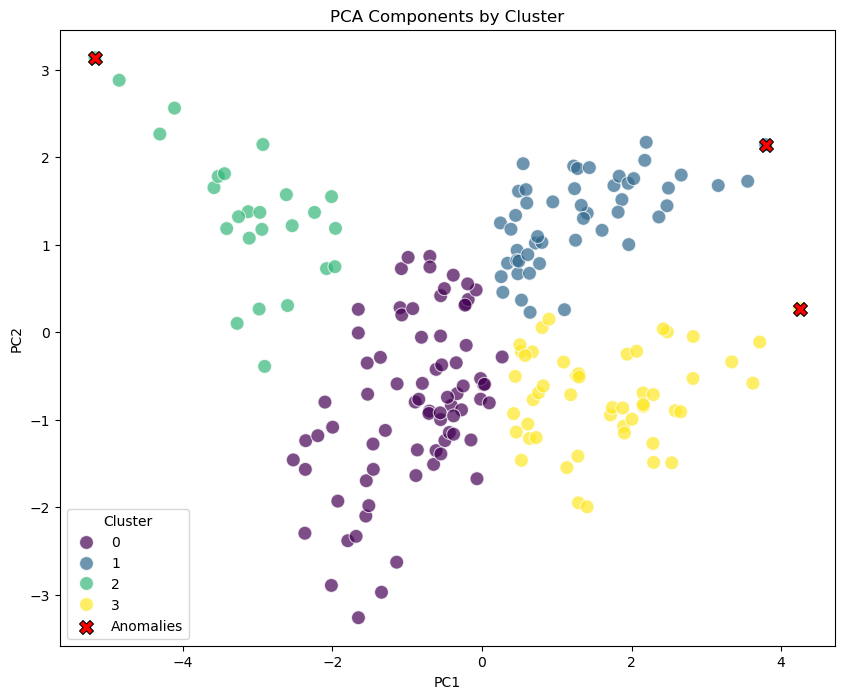

In [21]:
# scatter plot of PCA components colored by cluster
X_pca = pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(customer))
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=cluster_labels, palette='viridis', s=100, alpha=0.7)
sns.scatterplot(x=X_pca[anomaly_indices, 0], y=X_pca[anomaly_indices, 1],
                color='red', s=100, label='Anomalies', edgecolor='black', marker='X')
plt.title('PCA Components by Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

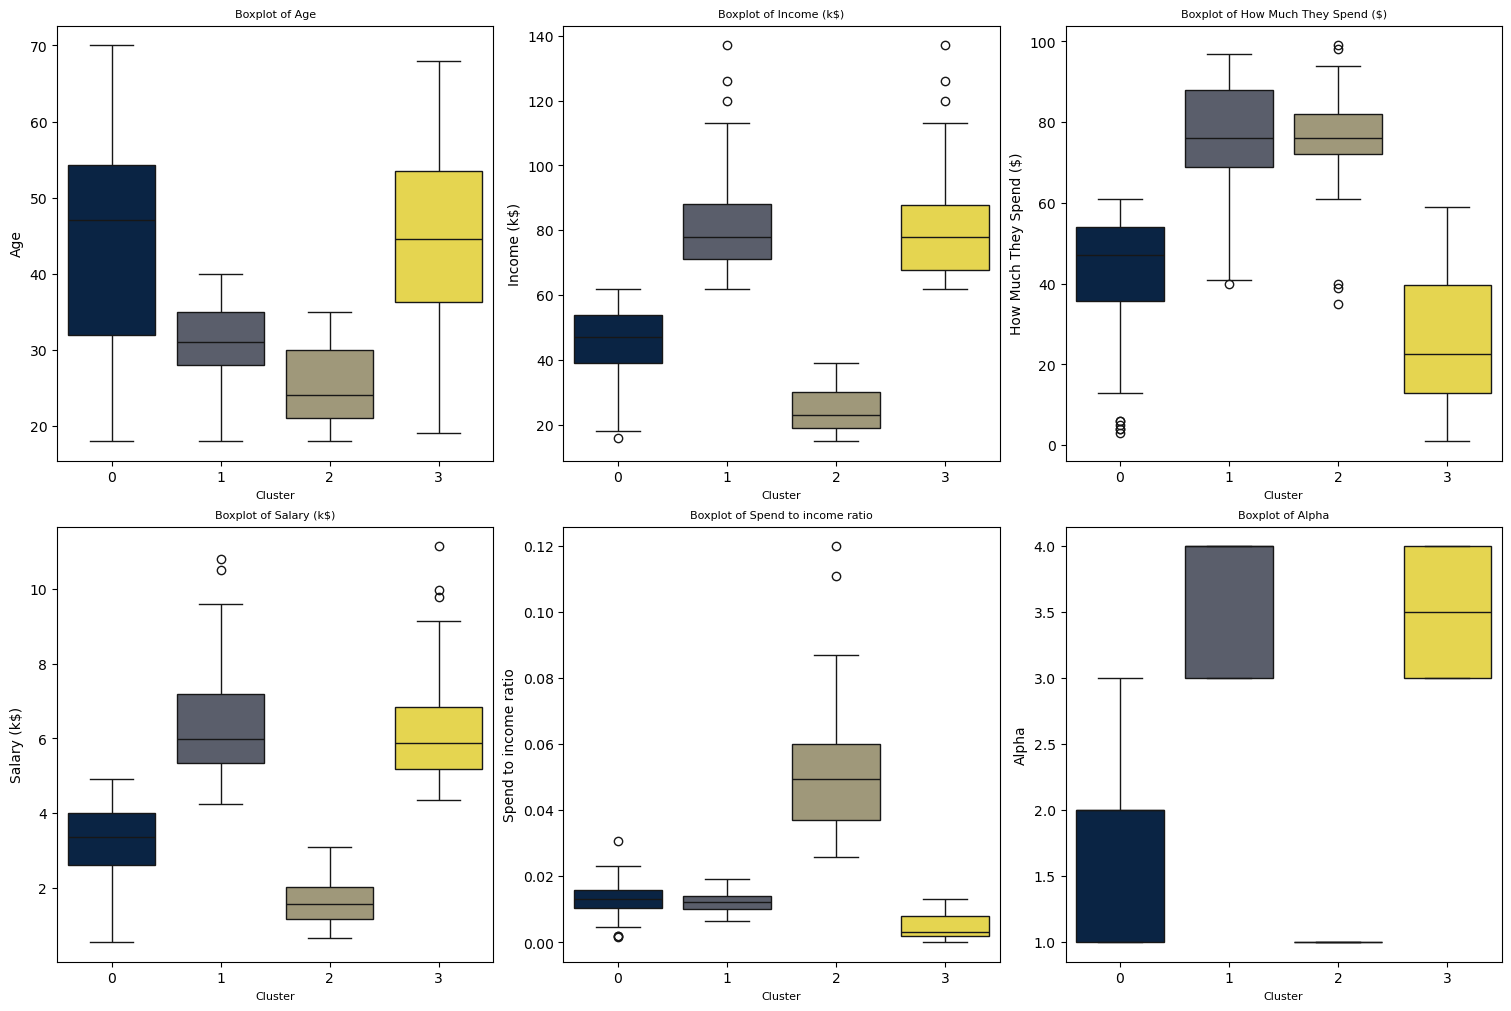

In [22]:
boxplot_by_cluster(customer_predicted, cluster_col='Cluster')

In [23]:
seaborn_palette = sns.color_palette("viridis", n_colors=4)
plotly_colors = [f"rgb({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)})" for c in seaborn_palette]

# scatter plot of inc ome vs spending by cluster
fig = go.Figure()
for cluster in sorted(customer_predicted['Cluster'].unique()):
  cluster_data = customer_predicted[customer_predicted['Cluster'] == cluster]
  fig.add_trace(go.Scatter(
    x=cluster_data['Income (k$)'],
    y=cluster_data['How Much They Spend ($)'],
    mode='markers',
    name=f'Cluster {cluster}',
    marker=dict(size=10, opacity=0.7, color=plotly_colors[cluster]),
    text=cluster_data.index
  ))
fig.add_trace(go.Scatter(
  x=customer_predicted.iloc[anomaly_indices]['Income (k$)'],
  y=customer_predicted.iloc[anomaly_indices]['How Much They Spend ($)'],
  mode='markers',
  name=f'Anomalies',
  marker=dict(
      symbol='star',
      size=6,
      color='black',
      opacity=0.7,
      line=dict(
          color='black',
          width=0.4
      ))
  ))
fig.update_layout(
    width=800,  # Set the width in pixels
    height=600,  # Set the height in pixels
    title='Income vs Spending by Cluster',
    xaxis_title='Income (k$)',
    yaxis_title='How Much They Spend ($)',
    legend_title='Cluster'
)
fig.show()

# (Optional) Matplotlib version for static visualization
# Uncomment to use matplotlib/seaborn instead of plotly
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=customer_predicted, x='Income (k$)', y='How Much They Spend ($)',
#                 hue='Cluster', palette='viridis', s=100, alpha=0.7)
# sns.scatterplot(data=customer_predicted.iloc[anomaly_indices], x='Income (k$)', y='How Much They Spend ($)',
#                 color='red', s=100, label='Anomalies', edgecolor='black', marker='X')
# plt.title('Income vs Spending by Cluster')
# plt.xlabel('Income (k$)')
# plt.ylabel('How Much They Spend ($)')
# plt.legend(title='Cluster')
# plt.show()


## T-sne

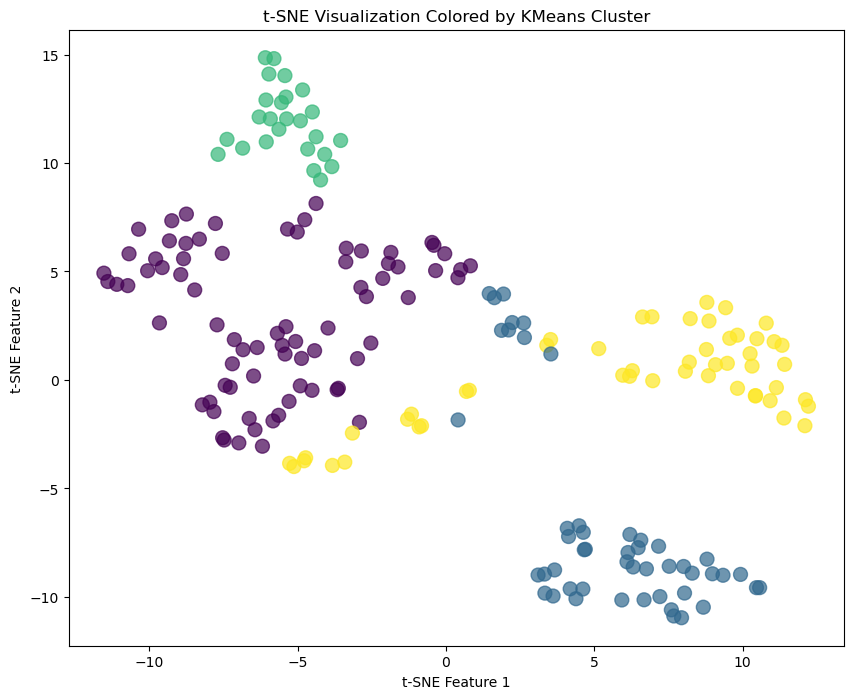

In [26]:
# Import TSNE
from sklearn.manifold import TSNE

# Create a TSNE instance: model
model = TSNE(learning_rate=100, random_state=42)

# Apply fit_transform to customer_transform: tsne_features
tsne_features = model.fit_transform(customer_transform)

# Extract the two TSNE features for plotting
xs = tsne_features[:, 0]
ys = tsne_features[:, 1]

# Use cluster_labels from KMeans as color
plt.figure(figsize=(10, 8))
plt.scatter(xs, ys, c=cluster_labels, cmap='viridis', s=100, alpha=0.7)
plt.title('t-SNE Visualization Colored by KMeans Cluster')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

# AgglomerativeClustering

In [80]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [81]:
# pipeline_agglomerative
pipeline_agglomerative = Pipeline([
    ('preprocessor', preprocessor),
    ("pca", PCA(n_components=2, random_state=42)),
    ('agglomerative', AgglomerativeClustering(n_clusters=4, compute_distances=True))
])

In [82]:
pipeline_agglomerative.fit(customer)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Age', 'Income (k$)', 'How Much They Spend ($)', 'Salary (k$)',
       'Spend to income ratio', 'Alpha'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Gender'])])),
                ('pca', PCA(n_components=2, random_state=42)),
                ('agglomerative',
                 AgglomerativeClustering(compute_distances=True,
                                         n_clusters=4))])

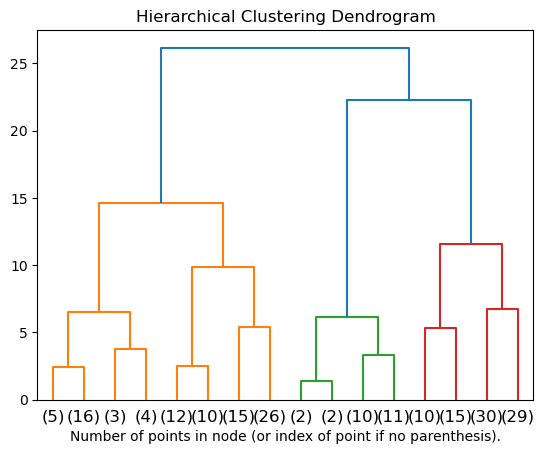

In [83]:
# Extract the fitted AgglomerativeClustering model from the pipeline
agglo_model = pipeline_agglomerative.named_steps['agglomerative']

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agglo_model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


```
pipeline_agglomerative = Pipeline([
    ('preprocessor', preprocessor),
    ("pca", PCA(n_components=2, random_state=42)),
    ('agglomerative', AgglomerativeClustering(n_clusters=4, compute_distances=True))
])
```

In [84]:
from sklearn.model_selection import ParameterGrid

param_grid = {"pca__n_components": [2, 3, 4],
              "agglomerative__n_clusters": [2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid = ParameterGrid(param_grid)
results = {}
pipeline_agglomerative = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(random_state=42)),
    ('agglomerative', AgglomerativeClustering(compute_distances=True))
])
for params in grid:
    # Set parameters for PCA and Agglomerative Clustering
    pipeline_agglomerative.set_params(**params)
    # Fit the pipeline and predict clusters
    cluster2 = pipeline_agglomerative.fit_predict(customer)

    # Calculate silhouette score
    score = silhouette_score(pipeline_agglomerative.named_steps['pca'].transform(pipeline_agglomerative.named_steps['preprocessor'].transform(customer)), cluster2)
    explained_variance = pipeline_agglomerative.named_steps['pca'].explained_variance_ratio_.sum()
    print(f"PCA={params['pca__n_components']}, Clusters={params['agglomerative__n_clusters']}: "
      f"Silhouette={silhouette_avg:.4f}, "
      f"Variance={explained_variance:.3f}")
    key = f"PCA_{params['pca__n_components']}_Agglomerative_{params['agglomerative__n_clusters']}"
    results[key] = {
      'pca_components': params['pca__n_components'],
      'n_clusters': params['agglomerative__n_clusters'],
      'silhouette_score': score,
      'explained_variance': explained_variance,
      # params key, value pair
      'params': params
      }





PCA=2, Clusters=2: Silhouette=0.2820, Variance=0.785
PCA=3, Clusters=2: Silhouette=0.2820, Variance=0.898
PCA=4, Clusters=2: Silhouette=0.2820, Variance=0.945
PCA=2, Clusters=3: Silhouette=0.2820, Variance=0.785
PCA=3, Clusters=3: Silhouette=0.2820, Variance=0.898
PCA=4, Clusters=3: Silhouette=0.2820, Variance=0.945
PCA=2, Clusters=4: Silhouette=0.2820, Variance=0.785
PCA=3, Clusters=4: Silhouette=0.2820, Variance=0.898
PCA=4, Clusters=4: Silhouette=0.2820, Variance=0.945
PCA=2, Clusters=5: Silhouette=0.2820, Variance=0.785
PCA=3, Clusters=5: Silhouette=0.2820, Variance=0.898
PCA=4, Clusters=5: Silhouette=0.2820, Variance=0.945
PCA=2, Clusters=6: Silhouette=0.2820, Variance=0.785
PCA=3, Clusters=6: Silhouette=0.2820, Variance=0.898
PCA=4, Clusters=6: Silhouette=0.2820, Variance=0.945
PCA=2, Clusters=7: Silhouette=0.2820, Variance=0.785
PCA=3, Clusters=7: Silhouette=0.2820, Variance=0.898
PCA=4, Clusters=7: Silhouette=0.2820, Variance=0.945
PCA=2, Clusters=8: Silhouette=0.2820, Variance

In [85]:
# Find best combinations
best_silhouette = max(results.items(), key=lambda x: x[1]['silhouette_score'])
best_variance = max(results.items(), key=lambda x: x[1]['explained_variance'])

print("ANALYSIS SUMMARY")
print(f"\nBest Silhouette Score:")
print(f"  Configuration: {best_silhouette[0]}")
print(f"  Score: {best_silhouette[1]['silhouette_score']:.4f}")
print(f"  PCA Components: {best_silhouette[1]['pca_components']}")
print(f"  Clusters: {best_silhouette[1]['n_clusters']}")
print(f"  Explained Variance: {best_silhouette[1]['explained_variance']:.3f}")

print(f"\nHighest Explained Variance:")
print(f"  Configuration: {best_variance[0]}")
print(f"  Variance: {best_variance[1]['explained_variance']:.3f}")
print(f"  PCA Components: {best_variance[1]['pca_components']}")
print(f"  Clusters: {best_variance[1]['n_clusters']}")
print(f"  Silhouette Score: {best_variance[1]['silhouette_score']:.4f}")

best_silhouette_params = best_silhouette[1]['params']

ANALYSIS SUMMARY

Best Silhouette Score:
  Configuration: PCA_3_Agglomerative_6
  Score: 0.4163
  PCA Components: 3
  Clusters: 6
  Explained Variance: 0.898

Highest Explained Variance:
  Configuration: PCA_4_Agglomerative_2
  Variance: 0.945
  PCA Components: 4
  Clusters: 2
  Silhouette Score: 0.2870


In [86]:
pipeline_agglomerative.set_params(**best_silhouette_params)
cluster2 = pipeline_agglomerative.fit_predict(customer)
customer_predicted['Cluster_Agglomerative'] = cluster2



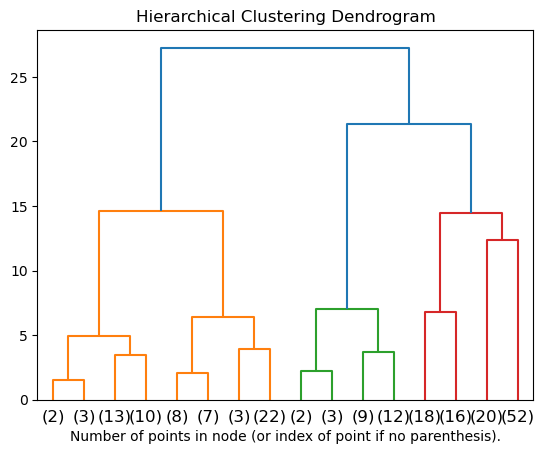

In [87]:
# Extract the fitted AgglomerativeClustering model from the pipeline
agglo_model = pipeline_agglomerative.named_steps['agglomerative']

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agglo_model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


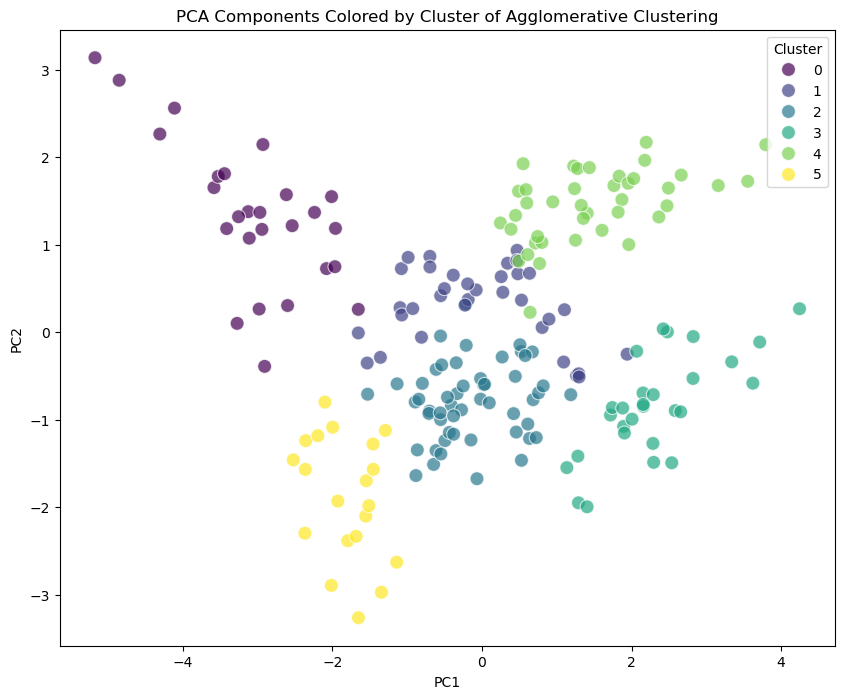

In [88]:
# scatter plot of PCA components colored by cluster of pipeline_agglomerative
X_pca = pipeline_agglomerative.named_steps['pca'].transform(pipeline_agglomerative.named_steps['preprocessor'].transform(customer))
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=cluster2, palette='viridis', s=100, alpha=0.7)
plt.title('PCA Components Colored by Cluster of Agglomerative Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

In [89]:
# Instead of matplotlib use plotly for 3D interactive visualization including cluster labels and legend
# Create a 3D scatter plot using Plotly
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='markers',
    marker=dict(
        color=cluster2,
        colorscale='Viridis',
        size=5,
        opacity=0.7,
        line=dict(width=1, color='DarkSlateGrey')
    ),
    text=[f'Cluster: {c}' for c in cluster2]
))
fig.update_layout(
    title='PCA Components Colored by Cluster of Agglomerative Clustering',
    legend_title='Cluster'
)
fig.show()


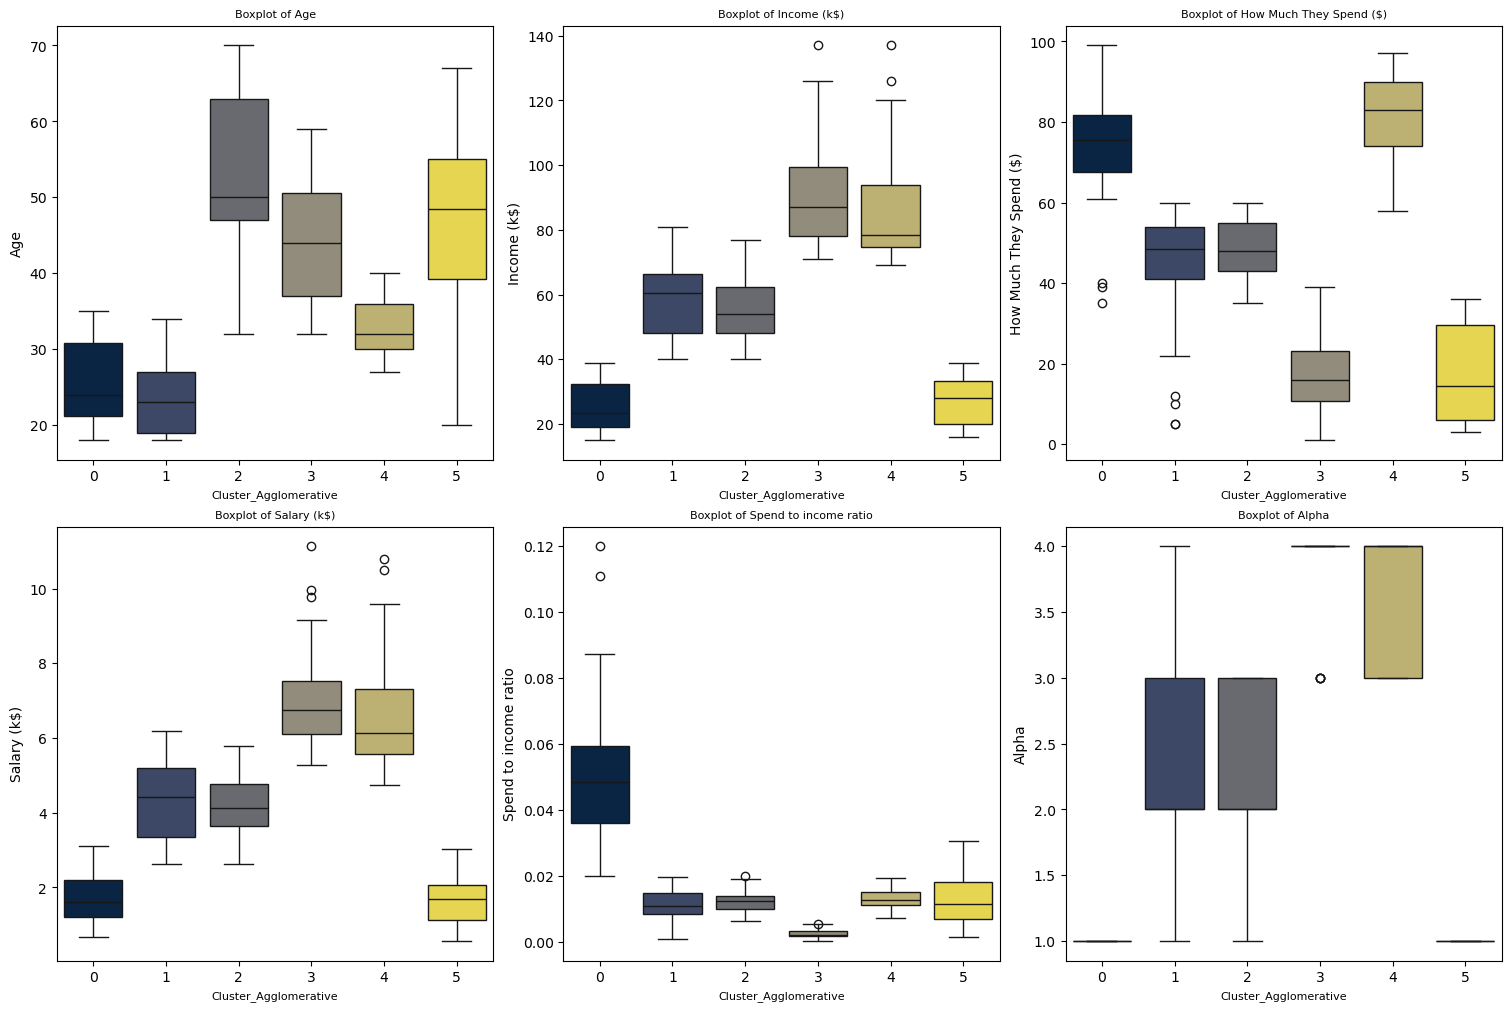

In [90]:
boxplot_by_cluster(customer_predicted, cluster_col='Cluster_Agglomerative')

In [91]:
# count the number of customers in each cluster sort by cluster label
cluster_counts = customer_predicted['Cluster_Agglomerative'].value_counts().sort_index()
print("\nNumber of customers in each cluster:")
print(cluster_counts)


Number of customers in each cluster:
Cluster_Agglomerative
0    26
1    34
2    52
3    28
4    40
5    20
Name: count, dtype: int64


In [92]:
feature_names = [p.split('__')[1] for p in pipeline_agglomerative.named_steps["preprocessor"].get_feature_names_out()]
pca_components = pipeline_agglomerative.named_steps["pca"].components_
pd.DataFrame(pca_components, columns=feature_names, index=[f'PC{i+1}' for i in range(pca_components.shape[0])])

,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha,Gender_Male
PC1,0.056365,0.530884,-0.086824,0.528402,-0.405556,0.513170,0.020472
PC2,-0.574183,0.157936,0.664878,0.162320,0.390621,0.154605,-0.021740
PC3,0.811195,0.047579,0.531868,0.045006,0.219562,0.077946,0.022512


### Analysis of Principal Components for Agglomerative Clustering Pipeline

The principal components (PCs) from the `pipeline_agglomerative` (with PCA) represent linear combinations of the original features that capture the most variance in the data. Below is an interpretation of the significant features for each principal component, based on the PCA components matrix:

| Feature                  | PC1 Weight | PC2 Weight | PC3 Weight |
|--------------------------|-----------|-----------|-----------|
| Age                      |   ~0.06   |  ~-0.57   |  ~0.81    |
| Income (k$)              |   ~0.53   |   ~0.16   |  ~0.05    |
| How Much They Spend ($)   |  ~-0.09   |   ~0.66   |  ~0.53    |
| Salary (k$)              |   ~0.53   |   ~0.16   |  ~0.05    |
| Spend to income ratio     |  ~-0.41   |   ~0.39   |  ~0.22    |
| Alpha                    |   ~0.51   |   ~0.15   |  ~0.08    |
| Gender_Male              |   ~0.02   |  ~-0.02   |  ~0.02    |

**PC1 (Principal Component 1):**
- **Strong positive weights:** `Income (k$)`, `Salary (k$)`, `Alpha`
- **Strong negative weight:** `Spend to income ratio`
- **Interpretation:** PC1 primarily distinguishes customers with higher income, salary, and Alpha values, while penalizing those with a high spend-to-income ratio. This component separates affluent customers with high earnings and low relative spending from those who spend a larger proportion of their income.

**PC2 (Principal Component 2):**
- **Strong positive weight:** `How Much They Spend ($)`
- **Strong negative weight:** `Age`
- **Moderate positive weight:** `Spend to income ratio`
- **Interpretation:** PC2 is mainly influenced by the actual amount spent (positive) and age (negative), with some influence from spend-to-income ratio. This component differentiates younger, high-spending customers from older, lower-spending ones.

**PC3 (Principal Component 3):**
- **Strong positive weights:** `Age`, `How Much They Spend ($)`
- **Interpretation:** PC3 captures a combination of age and spending, highlighting customers who are both older and spend more.

**Summary:**  
- **PC1**: Wealth and conservative spending.
- **PC2**: Spending behavior versus age.
- **PC3**: Age and spending combined.

These interpretations help explain how the PCA transformation summarizes the original features for clustering and visualization.

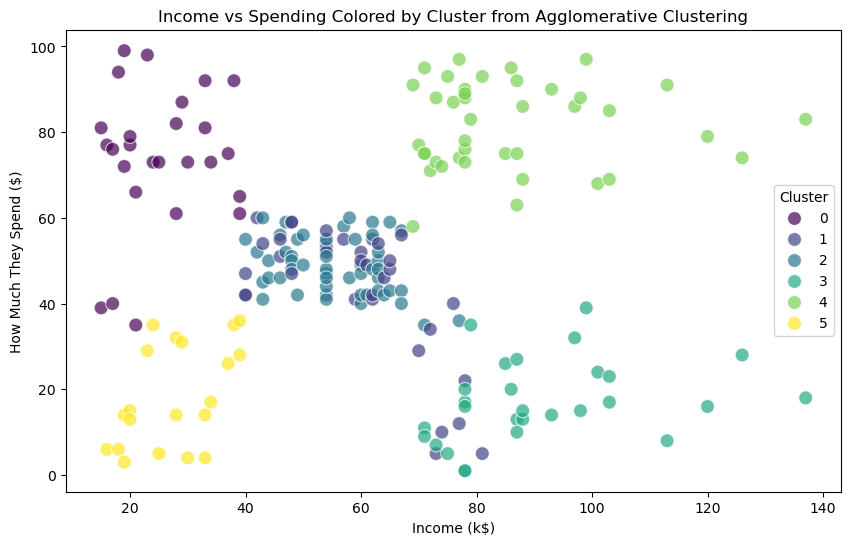

In [93]:
# scatter plot of income vs spending colored by cluster from pipeline_agglomerative 
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer, x='Income (k$)', y='How Much They Spend ($)',
                hue=cluster2, palette='viridis', s=100, alpha=0.7)
plt.title('Income vs Spending Colored by Cluster from Agglomerative Clustering') 
plt.xlabel('Income (k$)')
plt.ylabel('How Much They Spend ($)')
plt.legend(title='Cluster')
plt.show()


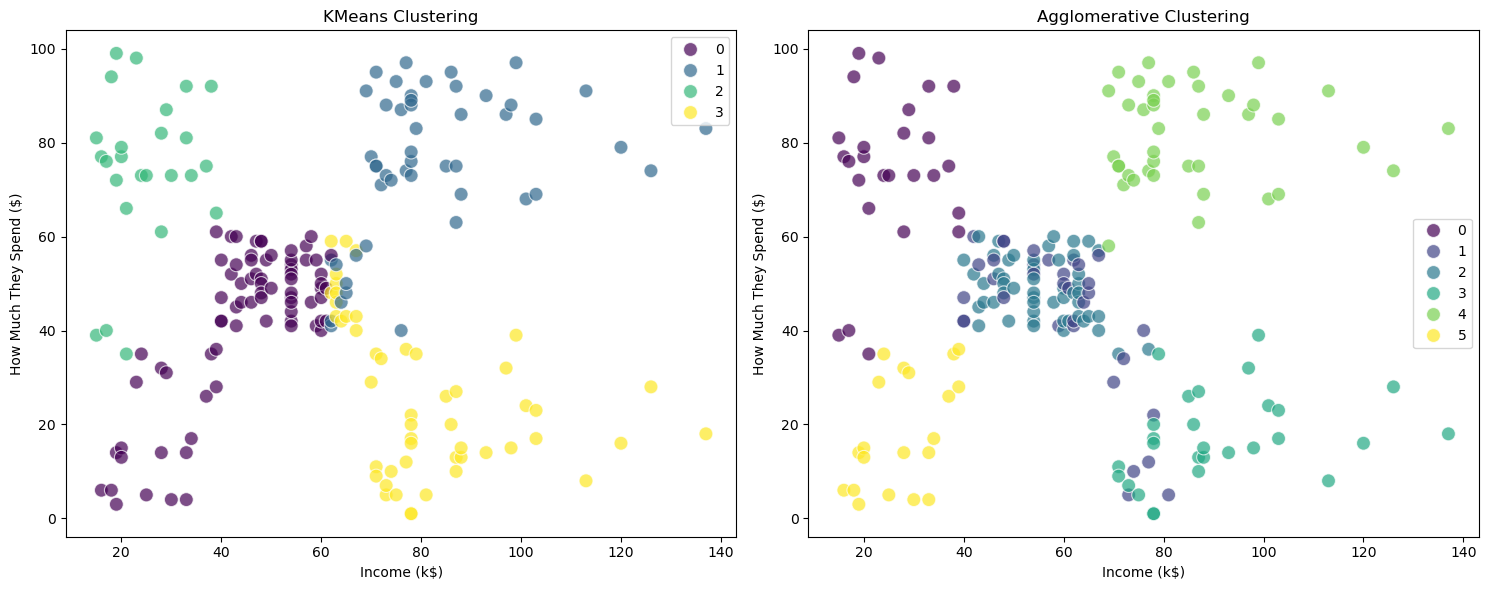

In [94]:
# side by side comparison of KMeans and Agglomerative Clustering scatter plots of income vs spending
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# KMeans scatter plot
sns.scatterplot(data=customer, x='Income (k$)', y='How Much They Spend ($)',
                hue=cluster_labels, palette='viridis', s=100, alpha  =0.7, ax=axes[0])
axes[0].set_title('KMeans Clustering')
axes[0].set_xlabel('Income (k$)')
axes[0].set_ylabel('How Much They Spend ($)')
# Agglomerative Clustering scatter plot
sns.scatterplot(data=customer, x='Income (k$)', y='How Much They Spend ($)',
                hue=cluster2, palette='viridis', s=100, alpha=0.7, ax=axes[1])
axes[1].set_title('Agglomerative Clustering')
axes[1].set_xlabel('Income (k$)')
axes[1].set_ylabel('How Much They Spend ($)')
plt.tight_layout()
plt.show()

## Comparison of KMeans and Agglomerative Clustering

The scatter plots below compare the clustering results of KMeans and Agglomerative Clustering on the customer dataset, using "Income (k$)" vs "How Much They Spend ($)" as axes.

- **KMeans Clustering** (left plot):  
  - Assigns clusters based on centroid optimization.
  - Tends to create clusters of similar size and shape (spherical).
  - Sensitive to initial centroid placement and outliers.
  - Cluster boundaries are typically linear.

- **Agglomerative Clustering** (right plot):  
  - Builds clusters hierarchically by merging the closest pairs.
  - Can form clusters of arbitrary shapes and sizes.
  - Less sensitive to outliers and initial conditions.
  - Cluster boundaries may be non-linear and adapt to data structure.

**Key Differences Highlighted:**
- The cluster assignments for some customers differ between the two methods, especially at the boundaries.
- KMeans may split or merge groups differently compared to Agglomerative, depending on the data distribution.
- Agglomerative clustering can capture more complex relationships, while KMeans is more efficient for large datasets.

By visually comparing the color groupings in both plots, you can observe how each algorithm segments the customer base differently.